# Investment Case Group Project
***
***

### [Prerequisites/ Downloads/ Project Information](http://nbviewer.jupyter.org/github/ab9bhatia/PythonScripts/blob/master/projects/Project_Spark_Funds/Spark_Funds_Information.ipynb)
***

#### Import Libraries and set required parameters

In [72]:
# numpy : Numerical & Scientific computing
import numpy as np

# pandas : for tabular data
import pandas as pd

# os : used for operating system dependent functionality
import os

# re : to handle regular expresiions
import re

# matplotlib : data visualization
import matplotlib.pyplot as plt
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline 

from IPython.display import Image # To view image from location/url

pd.options.mode.chained_assignment = None #set it to None to remove SettingWithCopyWarning
pd.options.display.float_format = '{:.2f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00



##### Import User Defined functions
I have created multiple functions([Click here to open](./Spark_User_defined_functions.ipynb)) w.r.t to Spark Funds case Study.
1. Impute Missing Values
2. Function to wite(.csv) a file to the current working directory.
3. Function to get the avg_funding_amount for any Funding type
4. Function demap, which will convert data in scattered crosstab input to two columns output.

In [73]:
%run Spark_User_defined_functions.ipynb

#### Input & Output Directory Path
#### IMPORTANT: Replace inputDir & outDir path with your directory path.

In [74]:
dirName = './'
inputFile = ('companies.txt','rounds2.csv','mapping.csv')

encoding = 'ANSI'
# 'iso-8859-1'

# List Input files present in current working directory
for fileName in os.listdir(dirName):
    if fileName.startswith(inputFile):
        print(fileName+'\t'+str(round((os.path.getsize(dirName+fileName)/1000),0))+' KB')

dynamic = False

# dynamic = True
# Note for the English Speaking Countries if you want to dynamically get the information from MySQL > MySQl > world database > 
# country & country language table.
# Run command as mentioned in prerequisite : conda install -c anaconda mysql-connector-python¶
# Run this sql on world db > INSERT INTO COUNTRYLANGUAGE VALUES('IND','English','T',4.5)

# dynamic = False
# Manually a column will be added(by referring pdf) in top9 dataframe called IsOfficialEN

companies.txt	8965.0 KB
mapping.csv	23.0 KB
rounds2.csv	11846.0 KB


In [75]:
inputFile[1]

'rounds2.csv'

## Checkpoint 1: Data Cleaning

##### Loading datasets into pandas dataframe.

In [76]:
companies = pd.read_csv(inputFile[0],sep='\t',encoding= encoding)
rounds2 = pd.read_csv(inputFile[1],encoding= encoding)

##### Get some insight

In [77]:
companies.head(2)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014


In [78]:
rounds2.head(2)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan


### Table 1.1
#### Q1. How many unique companies are present in rounds2?

In [79]:
# .nunique() wil give Unique count(excludes NA), use .lower() , to bring all values in lower case
# if you use .count(), it will only give total no of rows without excluding duplicates)

print(rounds2.company_permalink.str.lower().nunique())

66368


#### Q2. How many unique companies are present in companies?

In [80]:
print(companies.permalink.str.lower().nunique())

66368


#### Q3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.

In [81]:
#nunique() will give unique values for each column, column with maximum unique counts
#(or where total unique rows = total values in columns) can be considered as unique column

print(list(companies.nunique().sort_values(ascending=False).iloc[0:1].index))

['permalink']


#### Q4. Are there any companies in the rounds2 file which are not  present in companies ?

In [82]:
# Check the existacce of a unique column of dataframe1 in unique column of dataframe2
diff = rounds2[rounds2['company_permalink'].str.lower().isin(companies['permalink'].str.lower())== False]
print('Yes' if diff.company_permalink.count() > 0 else 'No')
diff

No


,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd


#### Q5. Merge the two data frames so that all  variables (columns)  in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame ?

In [83]:
# lower() the key columns of both dataframes, so they can match in case of diffence in case.
companies['permalink'] = companies['permalink'].str.lower()
rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
master_frame = pd.merge(left = companies,right = rounds2, how ='inner', left_on='permalink',right_on='company_permalink')
print('\nNumber of Records in master_frame: ',master_frame.count()[0])

# From here onwards we will work with master_frame only


Number of Records in master_frame:  114949


#### Identify missing values in the master_frame Dataframe

In [84]:
# sum of null values against each column
#master_frame.isnull().sum()

#### As our whole case study revolves around 'funding_round_type' & 'raised_amount_usd', so let's conentrate on these two columns.

In [85]:
master_frame.loc[:,['funding_round_type','raised_amount_usd']].isnull().sum()

funding_round_type        0
raised_amount_usd     19990
dtype: int64

#### UDF to Impute missing values

There are multiple ways to impute the missing values for numeric columns :

    1. Delete the row
        
    2. Replace missing value with mean value.
        
    3. Replace missing value with 0.
       

<b>Note</b>: You may get different answers based on the imputing approach you choose.Here we will take  <b>First approach</b> that is Delete the particular row.

[1.UDF : impute_numeric_values(dataframe,column,approach)](./Spark_User_defined_functions.ipynb) to impute missing values by passing following parameters.
*        dataframe :: Dataframe Name
*        column    :: Column name(numeric)
*        approach  :: 1,2,3 (default value 1) > 1,2,3 described above


In [86]:
# Using user defined function impute_numeric_values(dataframe,colname,approach)
master_frame_imputed = impute_numeric_values(master_frame,'raised_amount_usd',1)

# now check again for number of missing values, it should be 0
master_frame_imputed.loc[:,['funding_round_type','raised_amount_usd']].isnull().sum()


Number of Records (after imputing missing values):  94959


funding_round_type    0
raised_amount_usd     0
dtype: int64

#### Storing Data(master_frame_imputed)

In [87]:
# Storing master_frame_imputed dataframe at user location, we can use this dataframe while building plots.
#writeDF(dataframe = master_frame_imputed,outFileName = 'out_master_frame')

# We are not storing dataframe as of now as it will place 20+ MB file at user location

##### 'master_frame_imputed' is the final dataframe after Checkpoint 1
* --------------------------------------------------------------------------------------------------------------

## Checkpoint 2: Funding Type Analysis
### Table 2.1 ( Average Values of Investments for Each of these Funding Types)

#### Q1/2/3/4. Average funding amount of different funding type ?

#### [3.UDF: avg_funding_amount(funding_type)](./Spark_User_defined_functions.ipynb) 
To calculate <b>avg_funding_amount</b> by passing funding type as a variable, we will use it here.


In [88]:
print('venture\t\t' ,avg_funding_amount('venture'))
print('angel\t\t' ,avg_funding_amount('angel'))
print('seed\t\t' ,avg_funding_amount('seed'))
print('private_equity\t' ,avg_funding_amount('private_equity'))

venture		 11748949.13
angel		 958694.47
seed		 719818.0
private_equity	 73308593.03


#### Q5. Considering that Spark Funds wants to invest between 5 to 15 million USD per  investment round, which investment type is the most suitable for them?

In [89]:
# We can check from the last step that only funding type lies between 5 to 15 million is 'venture'
# Alternatively we can find the funding type through below code:

# Aggregate 'raised_amount_usd' on each 'funding_round_type' and check if 'raised_amount_usd' is between 5 to 15 million USD
most_suitable = master_frame_imputed.groupby(by='funding_round_type')[['raised_amount_usd']].mean()
most_suitable = most_suitable[(most_suitable.raised_amount_usd >= 5000000) & (most_suitable.raised_amount_usd <= 15000000)]

print('\nSo most suitable Funding Round Type is '+str(list(most_suitable.index)))
most_suitable


So most suitable Funding Round Type is ['venture']


,raised_amount_usd
funding_round_type,
venture,11748949.13


In [90]:
# Filter the master_frame dataset based on the above conditions(most_suitable funding_round_type)
master_frame_filtered = master_frame[master_frame.funding_round_type == most_suitable.index[0]]
print('\nNumber of Records in master_frame_filtered: ',master_frame_filtered.count()[0])
master_frame_filtered.head(2)
# Now master_frame_filtered contains the data where funding_round_type ='venture' & raised_amount_usd between 5 to 15 million.


Number of Records in master_frame_filtered:  55494


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan


## Checkpoint 3: Country Analysis
### Table 3.1 ( Analysing the Top 3 English-Speaking Countries)

In [91]:
top9 = master_frame_filtered.groupby('country_code')['raised_amount_usd'].sum().sort_values(ascending=False).reset_index()[0:9]

###### Add a new column identifier, IsOfficialEN in top9 dataframe.

In [92]:
# Now the requirement is to fetch top 3 countries from top 9 dataframe where official language is English, we will fetch this 
# information from MySQl > world database > country & country language table. Alternatively we can check this information
# from the pdf provided, but there we have to hardcode the information.

if dynamic:
    import mysql.connector as con
    db_connection = con.connect(host='localhost', database='world', user='root', password='mysql@123')
    query = 'select code,name from country where code in(SELECT countrycode FROM COUNTRYLANGUAGE WHERE LANGUAGE=%s AND ISOFFICIAL=%s)'
    countryEN =  pd.read_sql(sql =query,con =db_connection,params=['English','T'])
    top9['IsOfficialEN'] = top9.country_code.isin(countryEN['code'])
else:
    top9['IsOfficialEN'] = [True,False,True,True,True,False,False,False,False]
    # these values are added based on the pdf link of English Speaking Countries 
    #http://www.emmir.org/fileadmin/user_upload/admission/Countries_where_English_is_an_official_language.pdf
    
top9

,country_code,raised_amount_usd,IsOfficialEN
0,USA,422510842796.00,True
1,CHN,39835418773.00,False
2,GBR,20245627416.00,True
3,IND,14391858718.00,True
4,CAN,9583332317.00,True
5,FRA,7259536732.00,False
6,ISR,6907514579.00,False
7,DEU,6346959822.00,False
8,JPN,3363676611.00,False


#### Storing Data(top9)

In [93]:
# Storing top9 dataframe at user location, we can use this dataframe while building plots.
writeDF(top9,'out_top9')

File:out_top9.csv created at current working directory 
Size of file :	0.3 KB


#### Q1/2/3. Top/Second/Third English speaking country ?

In [94]:
top3 = top9[top9.IsOfficialEN].iloc[0:3,0:2].reset_index()
top = top3.country_code[0]
second = top3.country_code[1]
third = top3.country_code[2]

print('top\t',top)
print('second\t',second)
print('third\t',third)
top3.iloc[0:3,1:3]

top	 USA
second	 GBR
third	 IND


,country_code,raised_amount_usd
0,USA,422510842796.00
1,GBR,20245627416.00
2,IND,14391858718.00


In [95]:
# Filter master_frame_filtered dataset based on top 3 english speaking countries
top3_data = master_frame_filtered.loc[master_frame_filtered.country_code.isin(top3.country_code)]
print('\nNumber of Records: ',top3_data.count()[0])
top3_data.head(3)


Number of Records:  41667


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan
5,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,nan


## Checkpoint 4: Sector Analysis 1
### Table 5.1 ( Sector-wise Investment Analysis)

In [96]:
# first string before the | will be considered the primary sector.
# Add the new column in master_frame_filtered dataframe named as 'primary_sector'
top3_data['primary_sector'] = top3_data['category_list'].str.split('|').str.get(0)

print('\nNumber of Records: ',top3_data.count()[0])
top3_data.head(3)


Number of Records:  41667


,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,Media
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,nan,Application Platforms
5,/organization/004-technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010,/organization/004-technologies,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,24-07-2014,nan,Software


#### Read Mapping file

In [97]:
mapping =  pd.read_csv(inputFile[2],encoding= encoding)
print('Rows * Columns in mapping: ',mapping.shape) # shape includes NA

Rows * Columns in mapping:  (688, 10)


##### Clean Mapping.csv(replace 0 with na)

In [98]:
# There are multiple records in the dataset column category_list where 'na' is replaced by 0, so we have to replace 0 with na,
# we have to make sure if data contains 2.0 or v3.0 we should not replace it.

# In regex '.*' is for zero or more occurances before 0, '.+ is for one or more occurance after 0.

regex = (mapping.category_list.str.contains('[.*0]')==True) &  (mapping.category_list.str.endswith('0')==False)
mapping_cleaned = mapping.copy()
mapping_cleaned.loc[regex,'category_list'] = mapping_cleaned.loc[regex,'category_list'].replace('0','na',regex=True)
mapping_cleaned.head()

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


In [99]:
#pd.melt(mapping_cleaned, id_vars=['category_list'])

#### UDF to Map Category List with Main Sector

[4.UDF : demap(df,outColName)](./Spark_User_defined_functions.ipynb) which will convert data in scattered crosstab input to two columns output by passing two variables. 
*    df          :: datframe
*    outColName  :: Output column name.

In [100]:
mapping_new = demap(mapping_cleaned,'main_sector')
mapping_new.tail()

,category_list,main_sector
683,Wholesale,Others
684,Wine And Spirits,Entertainment
685,Wireless,Entertainment
686,Women,Others
687,Young Adults,Others


##### Merge Top3 data with mapping

In [101]:
top3_data_sector_wise = pd.merge(left=top3_data, right=mapping_new,left_on='primary_sector',right_on='category_list')
# Drop unnecessary columns
top3_data_sector_wise.drop(labels=['category_list_x', 'category_list_y'],axis=1, inplace=True)

print('\nNumber of Records: ',top3_data_sector_wise.count()[0])
top3_data_sector_wise.head(3)


Number of Records:  41497


,permalink,name,homepage_url,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
0,/organization/-fame,#fame,http://livfame.com,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.00,Media,Entertainment
1,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.00,Media,Entertainment
2,/organization/90min,90min,http://www.90min.com,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.00,Media,Entertainment


#### Storing Data (top3_data_sector_wise)

In [102]:
# Storing master_frame_sector_wise dataframe at user location
# top3_data_sector_wise :: Contains the data for top3 english speaking countries where a particular funding type falling 
#within the 5-15 million USD range.

#writeDF(top3_data_sector_wise,'out_top3_data_sector_wise')

## Checkpoint 5: Sector Analysis 2

Created three separate data frames D1, D2 and D3 for each of the three english countries containing the observations of funding type falling within the 5-15 million USD range.
The three data frames contains:
1. All the columns of the master_frame along with the primary sector and the main sector
2. The total number (or count) of investments for each main sector in a separate column
3. The total amount invested in each main sector in a separate column

In [103]:
#USA
D1 = top3_data_sector_wise[top3_data_sector_wise['country_code']==top]

#GBR
D2 = top3_data_sector_wise[top3_data_sector_wise['country_code']==second]

#IND
D3 = top3_data_sector_wise[top3_data_sector_wise['country_code']==third]

D1.head(3)

,permalink,name,homepage_url,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector
4,/organization/all-def-digital,All Def Digital,http://alldefdigital.com,operating,USA,CA,Los Angeles,Los Angeles,NaN,/organization/all-def-digital,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,A,06-08-2014,5000000.00,Media,Entertainment
5,/organization/audiosocket,Audiosocket,http://audiosocket.com,operating,USA,WA,Seattle,Seattle,01-05-2008,/organization/audiosocket,/funding-round/0959f59e3a89bc8db8c6ed9c646349fd,venture,NaN,02-05-2013,650000.00,Media,Entertainment
6,/organization/audiosocket,Audiosocket,http://audiosocket.com,operating,USA,WA,Seattle,Seattle,01-05-2008,/organization/audiosocket,/funding-round/4e3a53eec6c609943df752206070b23f,venture,A,02-09-2009,750000.00,Media,Entertainment


#### Q1. Total number of Investments (count)

In [104]:
print(D1.count()[0])
print(D2.count()[0])
print(D3.count()[0])

38209
2296
992


 #### Q2. Total amount of investment (USD)

In [105]:
print(D1.raised_amount_usd.sum())
print(D2.raised_amount_usd.sum())
print(D3.raised_amount_usd.sum())

421038036896.0
20156617818.0
14391858718.0


#### UDF to get top sectors count and name
[5.UDF : getSector(dataset,n,identifier)](./Spark_User_defined_functions.ipynb) will give you 'name of the sector' or 'count of investments in sectors' based on the following parameters.
*    dataset     :: datframe
*    n           :: n represents nth order, 0 for top, 1 for second top and so on.
*    identifier  :: identifier = 'count' to get the count, identifier = 'name' to get the sector name.

#### Q3. Top sector (based on count of investments)

In [106]:
D1_sec0_name = getSector(dataset=D1,n=0,identifier='name')
D2_sec0_name = getSector(D2,0,'name')
D3_sec0_name = getSector(D3,0,'name')

print('D1_sec0_name : ',D1_sec0_name,'\nD2_sec0_name : ',D2_sec0_name,'\nD3_sec0_name : ',D3_sec0_name)

D1_sec0_name :  Others 
D2_sec0_name :  Others 
D3_sec0_name :  Others


#### Q4. Second-best sector (based on count of investments)

In [107]:
D1_sec1_name = getSector(D1,1,'name')
D2_sec1_name = getSector(D2,1,'name')
D3_sec1_name = getSector(D3,1,'name')

print('D1_sec1_name : ',D1_sec1_name,'\nD2_sec1_name : ',D2_sec1_name,'\nD3_sec1_name : ',D3_sec1_name)

D1_sec1_name :  Cleantech / Semiconductors 
D2_sec1_name :  Social, Finance, Analytics, Advertising 
D3_sec1_name :  Social, Finance, Analytics, Advertising


#### Q5. Third-best sector (based on count of investments)

In [108]:
D1_sec2_name = getSector(D1,2,'name')
D2_sec2_name = getSector(D2,2,'name')
D3_sec2_name = getSector(D3,2,'name')

print('D1_sec2_name : ',D1_sec2_name,'\nD2_sec2_name : ',D2_sec2_name,'\nD3_sec2_name : ',D3_sec2_name)

D1_sec2_name :  Social, Finance, Analytics, Advertising 
D2_sec2_name :  Cleantech / Semiconductors 
D3_sec2_name :  News, Search and Messaging


#### Q6. Number of investments in the top sector (refer to point 3)

In [109]:
D1_sec0_count = getSector(D1,0,'count')
D2_sec0_count = getSector(D2,0,'count')
D3_sec0_count = getSector(D3,0,'count')

print('D1_sec0_count : ',D1_sec0_count,'\nD2_sec0_count : ',D2_sec0_count,'\nD3_sec0_count : ',D3_sec0_count)

D1_sec0_count :  8767 
D2_sec0_count :  580 
D3_sec0_count :  332


#### Q7. Number of investments in the second-best sector (refer to point 4)

In [110]:
D1_sec1_count = getSector(D1,1,'count')
D2_sec1_count = getSector(D2,1,'count')
D3_sec1_count = getSector(D3,1,'count')

print('D1_sec1_count : ',D1_sec1_count,'\nD2_sec1_count : ',D2_sec1_count,'\nD3_sec1_count : ',D3_sec1_count)

D1_sec1_count :  8121 
D2_sec1_count :  481 
D3_sec1_count :  193


#### Q8. Number of investments in the third-best sector (refer to point 5)

In [111]:
D1_sec2_count = getSector(D1,2,'count')
D2_sec2_count = getSector(D2,2,'count')
D3_sec2_count = getSector(D3,2,'count')

print('D1_sec2_count : ',D1_sec2_count,'\nD2_sec2_count : ',D2_sec2_count,'\nD3_sec2_count : ',D3_sec2_count)

D1_sec2_count :  7822 
D2_sec2_count :  460 
D3_sec2_count :  154


#### Q9. For the top sector count-wise (point 3), which company received the highest investment?

In [112]:
# Filter dataframes by top-sector names(Q3), then group by company name and sum the raised_amount_usd, then fetch highest value
D1_com0_invt = D1[D1.main_sector == D1_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D2_com0_invt = D2[D2.main_sector == D2_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
D3_com0_invt = D3[D3.main_sector == D3_sec0_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]

print('D1_com0_invt : ',D1_com0_invt,'\nD2_com0_invt : ',D2_com0_invt,'\nD3_com0_invt : ',D3_com0_invt)

D1_com0_invt :  SoFi 
D2_com0_invt :  OneWeb 
D3_com0_invt :  Flipkart


#### Q10. For the second-best sector count-wise (point 4), which company received the highest investment?

In [113]:
D1_com1_invt = D1[D1.main_sector == D1_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D2_com1_invt = D2[D2.main_sector == D2_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]
D3_com1_invt = D3[D3.main_sector == D3_sec1_name].groupby(by='name')['raised_amount_usd'].sum().sort_values(ascending=False).index[1]

print('D1_com1_invt : ',D1_com1_invt,'\nD2_com1_invt : ',D2_com1_invt,'\nD3_com1_invt : ',D3_com1_invt)

D1_com1_invt :  Juno Therapeutics 
D2_com1_invt :  Borro 
D3_com1_invt :  LYCOS Internet Limited


## Checkpoint 6: Plots

#### Q1. A plot showing the fraction of total investments (globally) in venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

##### Using Matplotlib

NameError: name 'outDir' is not defined

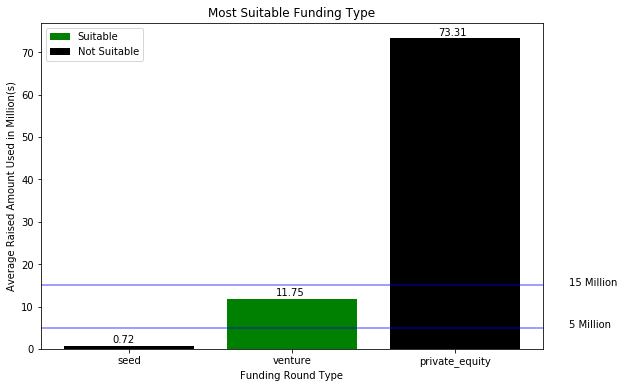

In [114]:
selected_funding_round_type = ['venture','seed','private_equity']
plot_frame = master_frame.loc[master_frame.funding_round_type.isin(selected_funding_round_type)]
plot_frame = plot_frame.groupby('funding_round_type')['raised_amount_usd'].mean().sort_values(ascending=True).reset_index()
#plot_frame_sum = plot_frame.groupby('funding_round_type')['raised_amount_usd'].sum().sort_values(ascending=True).reset_index()

cond = ((plot_frame.raised_amount_usd >= 5000000) & (plot_frame.raised_amount_usd <= 15000000))

#x_sum = range(len(plot_frame_sum.funding_round_type))
#y_sum = plot_frame_sum.raised_amount_usd/ 1000000

x = range(len(plot_frame.funding_round_type))
y = plot_frame.raised_amount_usd/ 1000000
y1 = y[cond]
y2 = y[~cond]
x1 = list(y1.index)
x2 = list(y2.index)

#plt.subplot(1,1,1)
plt.figure(figsize=(9,6))

# Bar plot
#plt.bar(x,y, color=cond.map({True: 'g', False: 'k'}),label ='Suitable' )
plt.bar(x1,y1, color='g',label ='Suitable' )
plt.bar(x2,y2, color='k',label ='Not Suitable' )


# Title
plt.title('Most Suitable Funding Type')

# Labels
plt.xlabel('Funding Round Type')
plt.ylabel('Average Raised Amount Used in Million(s)')

# Ticks
plt.xticks(x, plot_frame.funding_round_type)

# Horizontal Line
plt.axhline(y=5, color='b', linestyle='-',alpha = 0.5)
plt.text(max(x)+.7, 5,'5 Million')
plt.axhline(y=15, color='b', linestyle='-',alpha = 0.5)
plt.text(max(x)+.7, 15,'15 Million')

# Add Values to the bar
for i in x:
    plt.text(x[i]-.1,y[i]+.75,round(y[i],2))

# Legend
plt.legend()

# Save as image
plt.savefig(outDir+'Funding_Type.png',bbox_inches="tight")

# Show plot
plt.show()

In [ ]:
Image(filename = outDir + "Tableau/1 FundingType.png", width=980, height=900)

#### Q2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

In [ ]:
Image(filename = outDir + "Tableau/2 Top 9 Countries.png", width=900, height=800)

#### Q3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

In [ ]:
Image(filename = outDir + "Tableau/3 Top 3 Sectors.png", width=1000, height=1000)